In [50]:
import numpy as np
import wave
import os
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import random
import math

from numpy import genfromtxt

import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_hub as hub

subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21']
phonemes = ['goose','thought','zh','p','sh','n','k','fleece','trap','s','ng','t','f','z','m']

#returns audio time series
def extract_audio(fname):
    input_data = read(fname)
    audio = input_data[1]
    plt.plot(audio[0:len(audio)])
    return audio


#returns start and end time of significant sound in audio file
def isolate_sound(audio):
    start = 0
    end = 0
    start_found = False
    for frame in range(len(audio)):
        if audio[frame] > 100:
            end = frame
            if not start_found:
                start = frame
                start_found = True
    start_time = start/len(audio)
    end_time = end/len(audio)
    return start_time, end_time


#Determine windows within audio files when individual subject was sounding for each phoneme
def isolate_sound_batch(subject_name):
    
    wav_time_dict = {} #Tuples to start and end times indexed by wav audio file name
    phone_windows= []
    file_names = os.listdir('FEIS_dataset/wavs/'+subject_name+'/wavs')
    for fname in file_names:
        #print(fname)
        #audio = extract_audio('FEIS_dataset/wavs/'+subject_name+'/wavs/'+fname)
        wav_time_dict[fname] = (isolate_sound(audio))

    return wav_time_dict

Subject: 01
Subject: 02
Subject: 03
Subject: 04
Subject: 06
Subject: 07
Subject: 08
Subject: 09
Subject: 10
Subject: 11
Subject: 12
Subject: 13
Subject: 14
Subject: 15
Subject: 16
Subject: 17
Subject: 18
Subject: 19
Subject: 20
Subject: 21


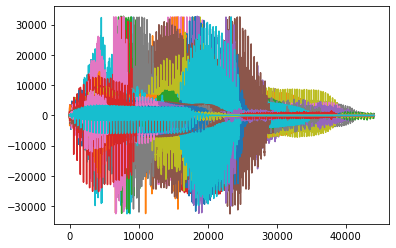

In [103]:
all_subject_phoneme_windows = []
for subject_name in subjects:
    print("Subject:",subject_name)
    all_phoneme_window_samples = []
    wav_time_dict = isolate_sound_batch(subject_name)
    for phone in range(len(phonemes)):
        fname = phonemes[phone]+'.wav'
        wav_start,wav_end = wav_time_dict[fname]
        audio = extract_audio('FEIS_dataset/wavs/'+subject_name+'/wavs/'+fname)

        start_frame = wav_start*len(audio)
        end_frame = wav_end*len(audio)

        window_size = int(len(audio)/1000 * 100) #50ms
        offset = window_size

        phoneme_window_samples = []
        frame = 0
        while frame < len(audio):
            if frame > start_frame and (frame + window_size) < end_frame:
                phoneme_window_samples.append(audio[frame:frame+window_size])
                frame = frame + offset
            else:
                frame += 1
        all_phoneme_window_samples.append(phoneme_window_samples)
    all_subject_phoneme_windows.append(all_phoneme_window_samples)

In [104]:
print(len(all_subject_phoneme_windows)) #nsubjects
print(len(all_subject_phoneme_windows[0])) #nphonemes
print(len(all_subject_phoneme_windows[0][0])) #nsample windows
print(len(all_subject_phoneme_windows[0][0][0])) #nframes in window

20
15
4
4410


In [105]:
x = []
t = []
for subject in all_subject_phoneme_windows:
    for phone in range(len(subject)):
        for sample in subject[phone]:
            x.append(sample)
            t.append(phone)

#Normalize Data
x = np.asarray(x)
mean = np.mean(x)
stdev = np.std(x)
for sample in range(len(x)):
    for chan in range(len(x[sample])):
        x[sample][chan] = (x[sample][chan] - mean) / stdev

print("nSamples:", len(x))
print("Mean Amplitude:",mean)
print("Standard Deviation:",stdev)

nSamples: 1215
Mean Amplitude: -2.70374084338811
Standard Deviation: 1251.608845666893


In [106]:
def split_data(x,t,training_size=0.8): #x=phoneme[i], t=target phoneme label

    #Identifies indices to split data by
    data_index = np.arange(len(t))
    random.shuffle(data_index)
    training_index = data_index[:int(training_size*len(t))]
    testing_index = data_index[int(training_size*len(t)):]

    training_x = []
    training_t = []
    for index in training_index:
        training_x.append(x[index])
        training_t.append(t[index])

    testing_x = []
    testing_t = []
    for index in testing_index:
        testing_x.append(x[index])
        testing_t.append(t[index])
        
    training_x = np.asarray(training_x)
    training_t = np.asarray(training_t)
    testing_x = np.asarray(testing_x)
    testing_t = np.asarray(testing_t)
    
    return training_x,training_t,testing_x,testing_t

In [107]:
training_x,training_t,testing_x,testing_t = split_data(x,t)
print("nTraining:", len(training_x))
print("nTesting:", len(testing_x))

input_shape = (training_x.shape[1:])
print(input_shape)

nTraining: 972
nTesting: 243
(4410,)


In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_shape)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000005)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4410)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1000)              4411000   
_________________________________________________________________
dense_53 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_55 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_56 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_57 (Dense)             (None, 1000)             

In [109]:
history = model.fit(training_x, training_t, epochs=150)

Epoch 1/150
31/31 [==============================] - 4s 69ms/step - loss: 2.7167 - accuracy: 0.0590
Epoch 2/150
31/31 [==============================] - 2s 58ms/step - loss: 2.6807 - accuracy: 0.1072
Epoch 3/150
31/31 [==============================] - 2s 58ms/step - loss: 2.6679 - accuracy: 0.0977
Epoch 4/150
31/31 [==============================] - 2s 58ms/step - loss: 2.6471 - accuracy: 0.1609
Epoch 5/150
31/31 [==============================] - 2s 57ms/step - loss: 2.6141 - accuracy: 0.2015
Epoch 6/150
31/31 [==============================] - 2s 59ms/step - loss: 2.6027 - accuracy: 0.2102
Epoch 7/150
31/31 [==============================] - 2s 57ms/step - loss: 2.6056 - accuracy: 0.2244
Epoch 8/150
31/31 [==============================] - 2s 59ms/step - loss: 2.5853 - accuracy: 0.2477
Epoch 9/150
31/31 [==============================] - 2s 61ms/step - loss: 2.5621 - accuracy: 0.2459
Epoch 10/150
31/31 [==============================] - 2s 59ms/step - loss: 2.5243 - accuracy: 0.2647

31/31 [==============================] - 2s 59ms/step - loss: 1.4982 - accuracy: 0.5170
Epoch 83/150
31/31 [==============================] - 2s 59ms/step - loss: 1.4774 - accuracy: 0.5284
Epoch 84/150
31/31 [==============================] - 2s 66ms/step - loss: 1.5208 - accuracy: 0.5166
Epoch 85/150
31/31 [==============================] - 3s 92ms/step - loss: 1.4489 - accuracy: 0.5334
Epoch 86/150
31/31 [==============================] - 3s 87ms/step - loss: 1.5359 - accuracy: 0.4928
Epoch 87/150
31/31 [==============================] - 2s 72ms/step - loss: 1.3953 - accuracy: 0.5477
Epoch 88/150
31/31 [==============================] - 3s 90ms/step - loss: 1.4858 - accuracy: 0.5206
Epoch 89/150
31/31 [==============================] - 3s 101ms/step - loss: 1.4291 - accuracy: 0.5439
Epoch 90/150
31/31 [==============================] - 3s 86ms/step - loss: 1.4947 - accuracy: 0.5040
Epoch 91/150
31/31 [==============================] - 2s 73ms/step - loss: 1.5010 - accuracy: 0.5086
Ep

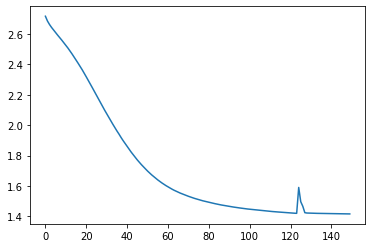

In [110]:
plt.plot(history.history['loss'])

In [111]:
def eval_model(train_x,train_t,test_x,test_t):

    train_loss, train_acc = model.evaluate(train_x,  train_t, verbose=2)
    print('Train accuracy:', train_acc)
    print()

    test_loss, test_acc = model.evaluate(test_x,  test_t, verbose=2)
    print('Test accuracy:', test_acc)

eval_model(training_x,training_t,testing_x,testing_t)

31/31 - 1s - loss: 1.4162 - accuracy: 0.5278
Train accuracy: 0.5277777910232544

8/8 - 0s - loss: 8.2973 - accuracy: 0.1358
Test accuracy: 0.1358024626970291


array([ 0,  0,  0, ...,  1,  0, -1], dtype=int16)

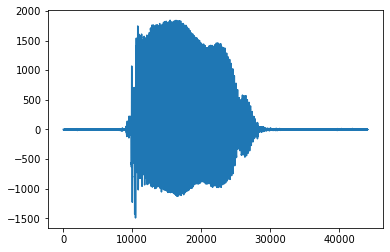

In [93]:
extract_audio('FEIS_dataset/wavs/'+'01'+'/wavs/'+'goose.wav')

EEG Word Encodings (Natural Speech Experiment)
---

In [199]:
#Load first natural speech subject & load data
wordVec = ['OLD', 'MAN', 'FISHED', 'ALONE', 'SKIFF', 'GULF', 'STREAM', 'GONE', 'EIGHTY', 'FOUR', 'DAYS', 'NOW', 'WITHOUT', 'TAKING', 'FISH', 'FIRST', 'FORTY', 'DAYS', 'BOY', 'FORTY', 'DAYS', 'WITHOUT', 'FISH', 'BOY', 'PARENTS', 'TOLD', 'OLD', 'MAN', 'NOW', 'DEFINITELY', 'FINALLY', 'WORST', 'FORM', 'UNLUCKY', 'BOY', 'GONE', 'ORDERS', 'ANOTHER', 'BOAT', 'CAUGHT', 'THREE', 'GOOD', 'FISH', 'FIRST', 'WEEK', 'MADE', 'BOY', 'SAD', 'SEE', 'OLD', 'MAN', 'COME', 'EACH', 'DAY', 'SKIFF', 'EMPTY', 'ALWAYS', 'WENT', 'DOWN', 'HELP', 'CARRY', 'EITHER', 'COILED', 'LINES', 'GAFF', 'HARPOON', 'SAIL', 'FURLED', 'AROUND', 'MAST', 'SAIL', 'PATCHED', 'FLOUR', 'SACKS', 'FURLED', 'LOOKED', 'LIKE', 'FLAG', 'PERMANENT', 'DEFEAT', 'OLD', 'MAN', 'THIN', 'GAUNT', 'DEEP', 'WRINKLES', 'BACK', 'NECK', 'BROWN', 'BLOTCHES', 'BENEVOLENT', 'SKIN', 'CANCER', 'SUN', 'BRINGS', 'REFLECTION', 'TROPIC', 'SEA', 'CHEEKS', 'BLOTCHES', 'RAN', 'WELL', 'DOWN', 'SIDES', 'FACE', 'HANDS', 'DEEP', 'CREASED', 'SCARS', 'HANDLING', 'HEAVY', 'FISH', 'CORDS', 'NONE', 'SCARS', 'FRESH', 'OLD', 'EROSIONS', 'FISHLESS', 'DESERT', 'EVERYTHING', 'OLD', 'EXCEPT', 'EYES', 'SAME', 'COLOR', 'SEA', 'CHEERFUL', 'UNDEFEATED', 'SANTIAGO', 'BOY', 'SAID', 'CLIMBED', 'BANK', 'SKIFF', 'HAULED', 'UP', 'COULD', 'GO', 'AGAIN', 'MADE', 'MONEY', 'OLD', 'MAN', 'TAUGHT', 'BOY', 'FISH', 'BOY', 'LOVED', 'OLD', 'MAN', 'SAID', 'LUCKY', 'BOAT', 'STAY', 'REMEMBER', 'HOW', 'WENT', 'EIGHTY', 'SEVEN', 'DAYS', 'WITHOUT', 'FISH', 'CAUGHT', 'BIG', 'ONES', 'DAY', 'THREE', 'WEEKS', 'REMEMBER', 'OLD', 'MAN', 'SAID', 'KNOW', 'LEAVE', 'ME', 'BECAUSE', 'DOUBTED', 'PAPA', 'MADE', 'ME', 'LEAVE', 'AM', 'BOY', 'MUST', 'OBEY', 'KNOW', 'OLD', 'MAN', 'SAID', 'QUITE', 'NORMAL', 'FAITH', 'OLD', 'MAN', 'SAID', 'YES', 'BOY', 'SAID', 'OFFER', 'BEER', 'TERRACE', 'TAKE', 'STUFF', 'HOME', 'WHY', 'OLD', 'MAN', 'SAID', 'BETWEEN', 'FISHERMEN', 'SAT', 'TERRACE', 'FISHERMEN', 'MADE', 'FUN', 'OLD', 'MAN', 'ANGRY', 'OTHERS', 'OLDER', 'FISHERMEN', 'LOOKED', 'SAD', 'SHOW', 'SPOKE', 'POLITELY', 'CURRENT', 'DEPTHS', 'DRIFTED', 'LINES', 'STEADY', 'GOOD', 'WEATHER', 'SEEN', 'SUCCESSFUL', 'FISHERMEN', 'DAY', 'ALREADY', 'BUTCHERED', 'MARLIN', 'CARRIED', 'LAID', 'FULL', 'LENGTH', 'ACROSS', 'TWO', 'PLANKS', 'TWO', 'MEN', 'STAGGERING', 'END', 'EACH', 'PLANK', 'FISH', 'HOUSE', 'WAITED', 'ICE', 'TRUCK', 'CARRY', 'MARKET', 'HAVANA', 'CAUGHT', 'SHARKS', 'TAKEN', 'SHARK', 'FACTORY', 'SIDE', 'COVE', 'HOISTED', 'BLOCK', 'TACKLE', 'LIVERS', 'REMOVED', 'FINS', 'CUT', 'OFF', 'HIDES', 'SKINNED', 'FLESH', 'CUT', 'STRIPS', 'SALTING']
onset_time = [1.12, 1.41, 2.08, 2.41, 2.95, 3.59, 3.9, 4.82, 5.08, 5.37, 5.59, 6.01, 6.25, 6.55, 7.0, 8.77, 9.09, 9.39, 9.82, 11.59, 11.91, 12.27, 12.6, 13.14, 13.43, 14.03, 14.72, 14.93, 15.33, 15.51, 16.39, 18.29, 18.66, 19.08, 20.59, 21.05, 21.57, 22.15, 22.47, 23.04, 23.3, 23.65, 24.01, 24.45, 24.87, 26.64, 26.9, 27.13, 27.65, 27.96, 28.17, 28.4, 28.78, 29.04, 29.66, 30.0, 30.82, 31.06, 31.22, 31.63, 31.98, 32.45, 32.87, 33.34, 34.13, 34.66, 35.8, 36.52, 36.96, 37.19, 38.67, 39.3, 39.93, 40.26, 41.33, 42.13, 42.37, 42.78, 43.34, 43.79, 46.01, 46.22, 46.71, 47.15, 47.8, 48.11, 48.73, 49.27, 50.55, 50.84, 51.66, 52.17, 52.51, 53.1, 53.39, 54.17, 54.86, 55.28, 56.16, 57.76, 58.2, 58.38, 58.61, 58.98, 59.6, 60.41, 61.09, 61.37, 61.82, 62.52, 62.9, 63.19, 63.68, 65.07, 65.58, 66.1, 67.69, 68.16, 68.98, 69.55, 71.72, 72.65, 72.98, 73.45, 74.51, 74.82, 75.39, 76.18, 76.9, 79.39, 80.4, 80.63, 81.35, 81.77, 82.46, 82.91, 83.14, 84.17, 84.34, 84.78, 85.48, 85.84, 87.74, 87.97, 88.33, 88.59, 88.87, 89.4, 89.6, 91.6, 91.79, 92.01, 93.36, 93.67, 94.22, 96.24, 96.6, 96.88, 97.04, 97.28, 97.55, 97.82, 98.09, 98.96, 99.17, 99.42, 99.87, 100.16, 100.39, 102.22, 103.06, 103.24, 103.49, 104.48, 105.18, 105.37, 105.48, 105.94, 107.93, 108.25, 108.56, 108.65, 109.41, 109.56, 110.12, 110.36, 111.85, 112.55, 112.72, 112.95, 114.04, 114.37, 116.6, 118.47, 118.67, 118.91, 122.44, 123.09, 123.3, 124.56, 125.03, 125.48, 126.32, 126.61, 126.89, 128.17, 129.12, 129.3, 129.52, 130.51, 130.89, 133.94, 134.36, 135.46, 135.86, 136.13, 136.53, 136.75, 137.95, 138.91, 139.52, 139.74, 140.32, 141.01, 142.43, 143.07, 143.34, 144.1, 144.8, 145.45, 145.93, 147.1, 147.4, 147.6, 148.77, 150.23, 150.86, 151.64, 152.07, 153.21, 153.82, 154.71, 155.36, 155.68, 155.9, 156.27, 156.63, 156.75, 157.63, 157.86, 158.13, 159.01, 159.21, 159.42, 160.42, 160.67, 161.2, 161.74, 161.97, 162.29, 162.93, 163.44, 165.48, 165.76, 166.35, 166.93, 167.24, 168.1, 168.49, 169.37, 169.92, 170.37, 171.27, 171.61, 172.58, 173.02, 173.21, 173.79, 174.19, 175.17, 175.57, 175.98, 176.48]
offset_time = [1.41, 1.79, 2.41, 2.77, 3.41, 3.9, 4.37, 5.08, 5.37, 5.59, 6.01, 6.25, 6.55, 6.95, 7.42, 9.09, 9.39, 9.77, 10.14, 11.91, 12.27, 12.56, 13.03, 13.36, 13.86, 14.28, 14.93, 15.16, 15.51, 16.24, 16.9, 18.66, 18.97, 19.67, 20.89, 21.31, 22.04, 22.47, 22.84, 23.3, 23.65, 24.01, 24.33, 24.87, 25.21, 26.83, 27.13, 27.56, 27.82, 28.17, 28.4, 28.66, 29.04, 29.27, 30.0, 30.31, 31.06, 31.22, 31.49, 31.83, 32.45, 32.77, 33.34, 33.92, 34.49, 35.27, 36.15, 36.96, 37.11, 37.76, 39.06, 39.74, 40.26, 40.79, 41.91, 42.37, 42.59, 43.18, 43.79, 44.35, 46.22, 46.46, 47.0, 47.65, 48.11, 48.57, 49.0, 49.63, 50.84, 51.47, 52.17, 52.51, 52.99, 53.39, 53.8, 54.64, 55.28, 55.65, 56.63, 58.2, 58.38, 58.61, 58.89, 59.29, 60.07, 60.87, 61.37, 61.82, 62.35, 62.9, 63.19, 63.47, 64.24, 65.29, 66.03, 66.57, 68.04, 68.83, 69.53, 70.05, 72.09, 72.98, 73.3, 73.94, 74.82, 75.16, 75.75, 76.74, 77.66, 80.08, 80.63, 80.9, 81.7, 82.11, 82.77, 83.14, 83.36, 84.34, 84.48, 85.14, 85.67, 86.22, 87.97, 88.17, 88.48, 88.76, 89.24, 89.6, 89.91, 91.79, 92.01, 92.36, 93.67, 94.07, 94.45, 96.6, 96.72, 97.04, 97.28, 97.55, 97.82, 98.09, 98.37, 99.17, 99.42, 99.67, 100.04, 100.39, 100.78, 102.74, 103.24, 103.49, 103.82, 104.65, 105.37, 105.48, 105.84, 106.48, 108.25, 108.56, 108.65, 109.06, 109.51, 109.84, 110.36, 110.66, 112.13, 112.72, 112.95, 113.31, 114.37, 114.78, 116.98, 118.67, 118.91, 119.24, 122.88, 123.3, 123.66, 124.83, 125.3, 125.94, 126.55, 126.89, 127.23, 128.36, 129.3, 129.52, 129.89, 130.89, 131.5, 134.15, 134.82, 135.86, 136.13, 136.3, 136.75, 137.16, 138.4, 139.32, 139.74, 140.26, 140.55, 141.5, 142.69, 143.33, 143.8, 144.59, 145.19, 145.78, 146.29, 147.4, 147.6, 147.98, 149.22, 150.86, 151.34, 151.88, 152.55, 153.65, 154.25, 155.1, 155.68, 155.9, 156.27, 156.63, 156.75, 157.46, 157.86, 158.13, 158.78, 159.12, 159.42, 159.8, 160.67, 161.02, 161.49, 161.97, 162.17, 162.56, 163.32, 163.9, 165.76, 166.18, 166.61, 167.24, 167.71, 168.34, 168.98, 169.75, 170.22, 170.76, 171.61, 172.11, 173.02, 173.21, 173.53, 174.19, 174.59, 175.57, 175.78, 176.37, 177.01]

emotiv_channels = [2, 24, 26, 28, 33, 45, 58, 70, 83, 96, 108, 117, 122, 124] #channel numbers map emotiv to 128 ch system
import scipy
word_data_raw = scipy.io.loadmat('Subject1_Run1.mat')
word_data = nat_data['eegData']

word_data_select = []
for chan in emotiv_channels:
    word_data_select.append(word_data.T[chan])

word_data_select = np.asarray(word_data_select).T
word_data_select.shape

nframes = len(word_data_select)
total_time = offset_time[-1] - onset_time[0]
EEG_freq_def = nframes / total_time

In [202]:
EEG_freq_def / 1000 * 50 #sampling is done at a drastically different rate..

6.523679572460061